In [1]:
#from datetime import datetime
import os
from datetime import datetime 
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import CSVLogger
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set()

Reading train dataset

In [3]:
train_data =  pd.read_csv('numerai_training_data.csv').drop(['id', 'data_type'], axis=1)

Checking which features have bad correlation with target fields. We may reduce amount of input fields to increase NN efficiency

In [4]:
target_columns = [column for column in train_data.columns if 'target' in column]
corr = train_data.corr('pearson')[target_columns].drop(target_columns, axis=0)
corr.style.format("{:.2}").background_gradient()

,target_bernie,target_charles,target_elizabeth,target_jordan,target_ken
feature1,-0.0095,-0.0099,-0.0084,-0.009,-0.0088
feature2,-0.0016,-0.0064,-0.0024,-0.0021,-0.0016
feature3,-0.0026,-0.00033,-0.00051,-0.00085,-0.002
feature4,-0.011,-0.0041,-0.011,-0.011,-0.011
feature5,0.0032,0.006,0.0046,0.0018,0.0024
feature6,0.02,0.016,0.021,0.02,0.02
feature7,0.013,0.0072,0.012,0.013,0.012
feature8,0.007,0.0046,0.0062,0.007,0.0061
feature9,0.015,0.011,0.015,0.014,0.014
feature10,-0.0054,0.00013,-0.0032,-0.0046,-0.0045


Features 28, 31, 37 have lowest values, therefore we can easily remove them in order to reduce input data

In [5]:
train_data.drop(['feature28', 'feature31', 'feature37'], axis=1, inplace=True)

Reading test dataset and removing same features as for train dataset

In [6]:
test_data = pd.read_csv('numerai_tournament_data.csv')
test_data.drop(['feature28', 'feature31', 'feature37'], axis=1, inplace=True)

Column 'era' is categorical field. It should be converted to numerical format

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(train_data['era'].append(test_data['era']))
train_data['era'] = label_encoder.transform(train_data['era'])
test_data['era'] = label_encoder.transform(test_data['era'])

Separation on target columns and train

In [8]:
y_data = train_data[[column for column in train_data.columns if 'target' in column]]
X_data = train_data[[column for column in train_data.columns if 'target' not in column]]

Extracting validation data

In [9]:
validation_df = test_data.loc[test_data.data_type == 'validation'].drop(['id', 'data_type'], axis=1)
validation_data = (validation_df[[column for column in validation_df.columns if 'target' not in column]],
                   {
                       'BERNIE': validation_df.target_bernie.values,
                       'CHARLES': validation_df.target_charles.values,
                       'KEN': validation_df.target_ken.values,
                       'ELIZABETH': validation_df.target_elizabeth.values,
                       'JORDAN': validation_df.target_jordan.values
                   })

Initialization for neural network. Amount of inputs should be equal to amount of remained features + era

In [10]:
inputs = Input(shape=(len(X_data.columns),))


Each target value should have same branch with different weights After each Dense layer we should use Dropout in order to avoid overfitting In the beginning we have 48 inputs, which are spread into 50 inputs. Amount of inputs dicreases till it reaches 1 (final output for branch) All values were selected after series of experiments

In [11]:
def get_basic_branch(input_layer):
    branch = Dense(50, activation='tanh')(input_layer)
    branch = Dropout(0.25)(branch)
    branch = Dense(20, activation='tanh')(branch)
    branch = Dropout(0.25)(branch)
    branch = Dense(10, activation='tanh')(branch)
    branch = Dropout(0.25)(branch)
    branch = Dense(5, activation='tanh')(branch)
    branch = Dropout(0.25)(branch)
    return branch

It's better to use sigmoid activation because it gives results which better suit or problem (output values are 0 or 1)

In [12]:
def get_bernie_branch(input_layer):
    branch = get_basic_branch(input_layer)
    branch = Dense(1, activation='sigmoid', name='BERNIE')(branch)
    return branch

In [13]:
def get_elizabeth_branch(input_layer):
    branch = get_basic_branch(input_layer)
    branch = Dense(1, activation='sigmoid', name='ELIZABETH')(branch)
    return branch

In [14]:
def get_jordan_branch(input_layer):
    branch = get_basic_branch(input_layer)
    branch = Dense(1, activation='sigmoid', name='JORDAN')(branch)
    return branch

In [15]:
def get_ken_branch(input_layer):        
    branch = get_basic_branch(input_layer)
    branch = Dense(1, activation='sigmoid', name='KEN')(branch)
    return branch

In [16]:
def get_charles_branch(input_layer):
    branch = get_basic_branch(input_layer)
    branch = Dense(1, activation='sigmoid', name='CHARLES')(branch)
    return branch

Creating and compiling model

In [17]:
model = Model(inputs=[inputs,], outputs=[get_bernie_branch(inputs),
                                         get_elizabeth_branch(inputs),
                                         get_jordan_branch(inputs),
                                         get_ken_branch(inputs),
                                         get_charles_branch(inputs)])
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Helper variables that were useful during model design

In [21]:
os.mkdir('runs')
os.mkdir('models')
os.mkdir('graphs')

In [22]:
name = datetime.strftime(datetime.now(), '%Y-%m-%d-%H-%M')
csv_path = f'runs/{name}.csv'
model_path = f'models/{name}.h5'
fig_path = f'graphs/{name}.png'
name

'2018-11-16-11-17'

In [23]:
model_path

'models/2018-11-16-11-17.h5'

Each run produces CSV output with accuracies and losses

In [24]:
csv_logger = CSVLogger(csv_path)

After experiments it was shown that 50 epochs are more than enough to train (and even a little bit overfit) model

In [25]:
epochs = 50
batch_size = int(len(X_data) / 30)

In [26]:
#with csvlogger
start_time = datetime.now()


result = model.fit(x=X_data.values, 
                   y={
                       'BERNIE': y_data.target_bernie.values,
                       'CHARLES': y_data.target_charles.values,
                       'KEN': y_data.target_ken.values,
                       'ELIZABETH': y_data.target_elizabeth.values,
                       'JORDAN': y_data.target_jordan.values
                   },
                   batch_size=batch_size,
                   epochs=epochs,                   
                   callbacks=[csv_logger], 
                   validation_data=validation_data, 
                   verbose=False)

print ('Time elapsed:', datetime.now() - start_time)

Time elapsed: 0:07:02.756643


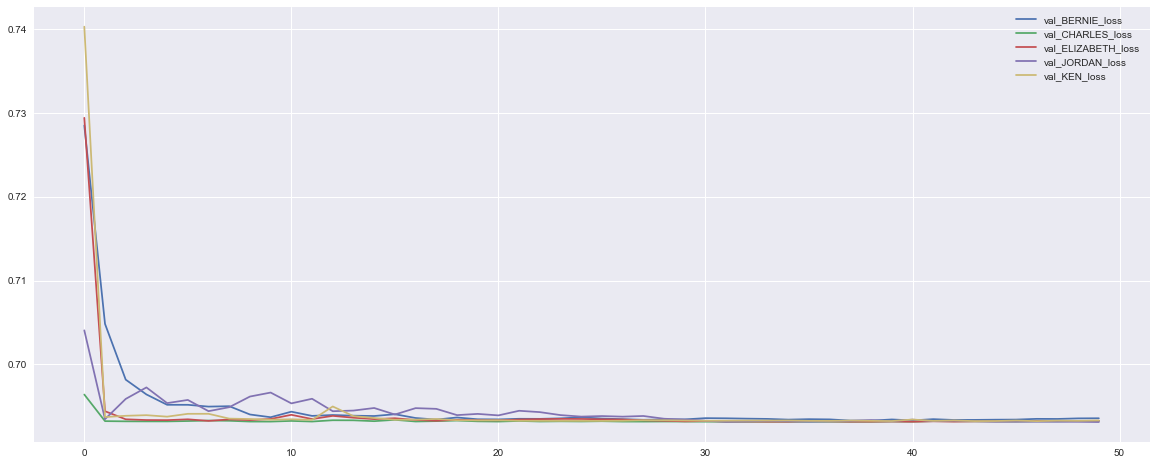

In [27]:
import re
df = pd.read_csv(csv_path)
columns = [column for column in df.columns if re.match(r'val_.+_loss', column)]
fig = df[columns].plot.line(figsize=(20, 8)).get_figure()
fig.savefig(fig_path)

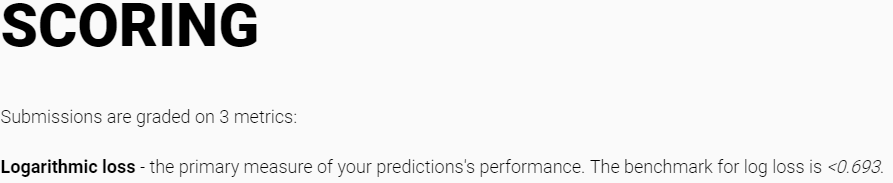

In [28]:
for column in columns:    
    print(f"Best in {column}: {min(result.history[column])}")

for column in columns:    
    print(f"Last in {column}: {result.history[column][-1]}")

Best in val_BERNIE_loss: 0.6932988188893536
Best in val_CHARLES_loss: 0.6931701984585169
Best in val_ELIZABETH_loss: 0.693173199670987
Best in val_JORDAN_loss: 0.6931357462330829
Best in val_KEN_loss: 0.6932417164621046
Last in val_BERNIE_loss: 0.6935845253167178
Last in val_CHARLES_loss: 0.6932655559521532
Last in val_ELIZABETH_loss: 0.693278691335842
Last in val_JORDAN_loss: 0.6931357462330829
Last in val_KEN_loss: 0.693326547048961


In [29]:
X_data_submission = test_data.drop(['id', 'data_type'] + target_columns, axis=1)
output = model.predict(X_data_submission)

In [30]:
# Bernie
df_bernie = pd.DataFrame({'id': test_data.id.values,
                          'probability_bernie': [item[0] for item in output[0]]})
df_bernie.to_csv('bernie.csv', index=False)
# Elizabeth
df_bernie = pd.DataFrame({'id': test_data.id.values,
                          'probability_elizabeth': [item[0] for item in output[1]]})
df_bernie.to_csv('elizabeth.csv', index=False)
# Jordan
df_bernie = pd.DataFrame({'id': test_data.id.values,
                          'probability_jordan': [item[0] for item in output[2]]})
df_bernie.to_csv('jordan.csv', index=False)
# Ken
df_bernie = pd.DataFrame({'id': test_data.id.values,
                          'probability_ken': [item[0] for item in output[3]]})
df_bernie.to_csv('ken.csv', index=False)
# Charles
df_bernie = pd.DataFrame({'id': test_data.id.values,
                          'probability_charles': [item[0] for item in output[4]]})
df_bernie.to_csv('charles.csv', index=False)